In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import itertools
import random
import pandas as pd
import seaborn as sns
import matplotlib 
import math

sns.set(color_codes=True)
# matplotlib.rcParams['figure.figsize'] = (25, 4)

In [2]:
data = defaultdict(list)

params = {0: [{'pi': 0.5, 'mu': 40, 'sigma': 5},
                {'pi': 0.5, 'mu': 85, 'sigma': 5}],
          1: [{'pi': 0.5, 'mu': 25, 'sigma': 5},
                {'pi': 0.5, 'mu': 50, 'sigma': 5}]
         }

total_toss = 2000

In [3]:
for p in params: 
    param = params[p]
    num_clusters = len(param)
    for i in range(total_toss):
        Z = np.random.choice(num_clusters, 1, p=[param[i]['pi'] for i in range(num_clusters)])[0]

        data[p].append(np.random.normal(param[Z]['mu'], param[Z]['sigma'], 1)[0])

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Data distribution: Parent 1'}, xlabel='x', ylabel='pdf(x)'>

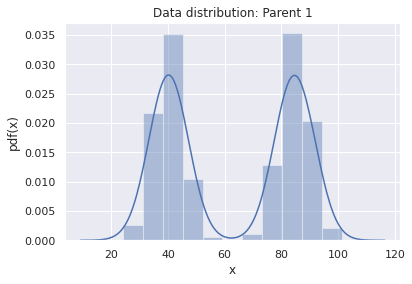

In [5]:
x = list(data[0])

plt.title("Data distribution: Parent 1")
plt.xlabel("x")
plt.ylabel("pdf(x)")
sns.set_style('whitegrid')
sns.distplot(np.array(x))

/home/fusemachines/.cache/pypoetry/virtualenvs/poetry-env-H-6CZZOK-py3.8/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Data distribution: Parent 2'}, xlabel='x', ylabel='pdf(x)'>

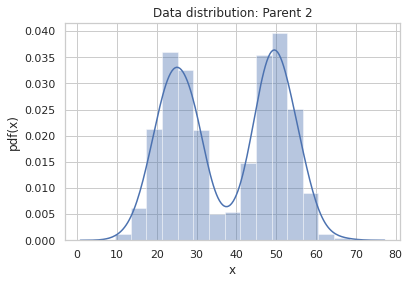

In [6]:
x = list(data[1])

plt.title("Data distribution: Parent 2")
plt.xlabel("x")
plt.ylabel("pdf(x)")
sns.set_style('whitegrid')
sns.distplot(np.array(x))

### Sample mean and data from normal gamma distributions

In [7]:
def sample_mu_sigma_with_data(data, m=50, c=1, a=1, b=1):

    N = np.size(data)

    C = c + N
    A = a + (N/2)
    M = ((c*m) + (np.sum(data)))/C
    B = b + (0.5 * (c*m**2 - C*M**2 + np.sum(data**2)))

    precision = np.random.gamma(shape=A, scale=1/B, size=1)[0]

    sigma = np.sqrt(1/precision)
    c_root = np.sqrt(1/C)

    mu = np.random.normal(loc=M, scale=sigma*c_root, size=1)[0]

    return mu, sigma

def sample_mu_sigma_without_data(m=50, c=1, a=1, b=1):

    precision = np.random.gamma(shape=a, scale=1/b, size=1)[0]

    sigma = np.sqrt(1/precision)

    c_root = np.sqrt(1/c)

    mu = np.random.normal(loc=m, scale=sigma*c_root, size=1)[0]

    return mu, sigma

### Probability density function

In [8]:
def gaussian_pdf(x, mean, sigma):
    return np.exp(-1.0 * ((x - mean)**2)/(2 * sigma**2))/np.sqrt(2 * np.pi * sigma**2)

### Random Initialise Clusters 

In [10]:
def set_data_type(ddata, cluster_type):

    data_type = []

    k_cluster = len(cluster_type)

    for i in range(len(ddata)):
        data_type.append(np.random.choice(cluster_type, 1, p=[1/k_cluster for i in range(k_cluster)])[0])

    return data_type

In [11]:
total_cluster_type = {
    0: {
        'mu': 0.0,
        'sigma': 0.0,
        'child': {
            0: [0], # Restaurant 0 Dish 0
            1: [0]  # Restaurant 1 Dish 0
            }
      },
    1: {
        'mu': 0.0,
        'sigma': 0.0,
        'child': {
            0: [0], # Restaurant 0 Dish 0
            1: [0]  # Restaurant 1 Dish 0
            }
      }
  }


random_Z = defaultdict(list)

for d in data:
    d_cluster = []
    for t in total_cluster_type:
        d_cluster.extend(total_cluster_type[t]['child'][d])

    random_Z[d].extend(set_data_type(data[d], d_cluster))

### Distribute data into clusters 

In [13]:
alpha = 2.0 
beta = 2.0 

def cluster_data(z, p, i):
    new_data = []
    
    child_clusters = defaultdict(list)
    
    for child_z in data:
        c_data = total_cluster_type[p]["child"][child_z]
        
        clusters_data = []

        child_data = data[child_z]
        
        for index in range(len(child_data)):
            if index == i:
                continue
            if random_Z[child_z][index] in c_data:
                clusters_data.append(child_data[i])
                
        if not len(c_data) == 0:
            child_clusters[child_z].extend(c_data)
        
        new_data.extend(clusters_data)
            
    for key in child_clusters:
        for c_data in child_clusters[key]:
            if c_data not in random_Z[key]:
                total_cluster_type[p]["child"][key].remove(c_data)
    
    return new_data

In [14]:
def calculate_class_prob(z, random_Z, i):

    z_type = random_Z[z]
    data_i = p_data[i]

    deleted_cluster_type = []
    k_prob = {}

    for k in total_cluster_type:

        new_data = cluster_data(z, k, i)

        if len(new_data) == 0:
            deleted_cluster_type.append(k)
            continue

        # Sample mean and sigma from Normal Gamma Distribution 
        mu, sigma = sample_mu_sigma_with_data(np.array(new_data))
        total_cluster_type[k]['mu'] = mu
        total_cluster_type[k]['sigma'] = sigma
        
    # Remove unnecessary parent cluster
    for d in deleted_cluster_type:
        del total_cluster_type[d]

    # Sample mean and sigma from Normal Gamma Distribution with only prior
    new_mu, new_sigma = sample_mu_sigma_without_data()

    # Calculate probability for existing table and dish type
    for k in total_cluster_type:
        mu = total_cluster_type[k]['mu']
        sigma = total_cluster_type[k]['sigma']

        k_prob[k] = gaussian_pdf(data_i, mu, sigma)

    #  Calculate probability for new table and existing dish type
    C = len(p_data)
    count_z_type = Counter(z_type)

    child_class_prob = {}

    for k in total_cluster_type:
        child_cluster = total_cluster_type[k]['child'][z]
        for c in child_cluster:
            c_prob = (count_z_type[c]/(C + alpha - 1)) * k_prob[k] # existing table,
            child_class_prob[c] = c_prob

    new_child_cluster_prob = (alpha / (C + alpha - 1)) * gaussian_pdf(data_i, new_mu, new_sigma)

    # Calculate probability for new table and new dish type
    count_parent_z_type = {}

    for k in total_cluster_type:
        count_parent_z_type[k] = len(np.array(list(total_cluster_type[k]['child'].values())).flatten())
  
    P = sum(count_parent_z_type.values())

    parent_class_prob = {}

    for k in total_cluster_type:
        parent_prob = new_child_cluster_prob * (count_parent_z_type[k] / (P + beta - 1)) #New table, existing dishes
        parent_class_prob[k] = parent_prob
  
    new_parent_class_prob = [new_child_cluster_prob * beta / (P + beta - 1)] #New table, new dishes prob

    return child_class_prob, parent_class_prob, new_parent_class_prob

In [15]:
num_iter = 100

# Tracking log likelihood
total_performance = []

for n_iter in range(num_iter):
    performance = []
    
    for z_type in data:
        p_data = data[z_type]

        for i in range(len(p_data)):

            # Getting all possible scenario probability
            child_class_prob, parent_class_prob, new_parent_class_prob = calculate_class_prob(z_type, random_Z, i)

            final_prob = list(child_class_prob.values()) + list(parent_class_prob.values()) + new_parent_class_prob
            
            performance.append(np.log(np.sum(final_prob)))
            
            total_prob = np.sum(final_prob)

            final_prob = [p/total_prob for p in final_prob]

            # Sampling the scenario according to the probability
            child_cluster_type = [str(c_class) for c_class in list(child_class_prob.keys())]
            parent_cluster_type = ['p_class' + str(p_class) for p_class in list(parent_class_prob.keys())]
            new_parent_cluster_type = ['p_class' + str(max(list(parent_class_prob.keys())) + 1)]

            overall_cluster_type = child_cluster_type + parent_cluster_type +  new_parent_cluster_type
            final_type = np.random.choice(overall_cluster_type, 1, p=final_prob)[0]

            if final_type in child_cluster_type:
                random_Z[z_type][i] = int(final_type)

            elif final_type in parent_cluster_type:
                old_parent_cluster = int(final_type.replace('p_class', ""))
                new_child_cluster = max(list(child_class_prob.keys())) + 1
                random_Z[z_type][i] = new_child_cluster

                total_cluster_type[old_parent_cluster]['child'][z_type].append(new_child_cluster)

            else:
                new_parent_cluster = max(list(parent_class_prob.keys())) + 1
                new_child_cluster = max(list(child_class_prob.keys())) + 1
                random_Z[z_type][i] = new_child_cluster

                total_cluster_type[new_parent_cluster] =  {'mu': 0.0, 'sigma': 0.0,'child': {}}

                for each_z_type in data:
                    if each_z_type == z_type:
                        total_cluster_type[new_parent_cluster]['child'][each_z_type] = [new_child_cluster]
                    else:
                        total_cluster_type[new_parent_cluster]['child'][each_z_type] = []

    total_performance.append(np.sum(performance))

    print("Iteration:", n_iter, "Number of Parent Cluster:", len(total_cluster_type))

/tmp/ipykernel_9858/2512632214.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  count_parent_z_type[k] = len(np.array(list(total_cluster_type[k]['child'].values())).flatten())


Iteration: 0 Number of Parent Cluster: 3
Iteration: 1 Number of Parent Cluster: 3
Iteration: 2 Number of Parent Cluster: 3
Iteration: 3 Number of Parent Cluster: 3
Iteration: 4 Number of Parent Cluster: 3
Iteration: 5 Number of Parent Cluster: 3
Iteration: 6 Number of Parent Cluster: 3
Iteration: 7 Number of Parent Cluster: 3
Iteration: 8 Number of Parent Cluster: 3
Iteration: 9 Number of Parent Cluster: 3
Iteration: 10 Number of Parent Cluster: 3
Iteration: 11 Number of Parent Cluster: 3
Iteration: 12 Number of Parent Cluster: 3
Iteration: 13 Number of Parent Cluster: 3
Iteration: 14 Number of Parent Cluster: 3
Iteration: 15 Number of Parent Cluster: 3
Iteration: 16 Number of Parent Cluster: 3
Iteration: 17 Number of Parent Cluster: 3
Iteration: 18 Number of Parent Cluster: 3
Iteration: 19 Number of Parent Cluster: 3
Iteration: 20 Number of Parent Cluster: 3
Iteration: 21 Number of Parent Cluster: 3
Iteration: 22 Number of Parent Cluster: 3
Iteration: 23 Number of Parent Cluster: 3
It

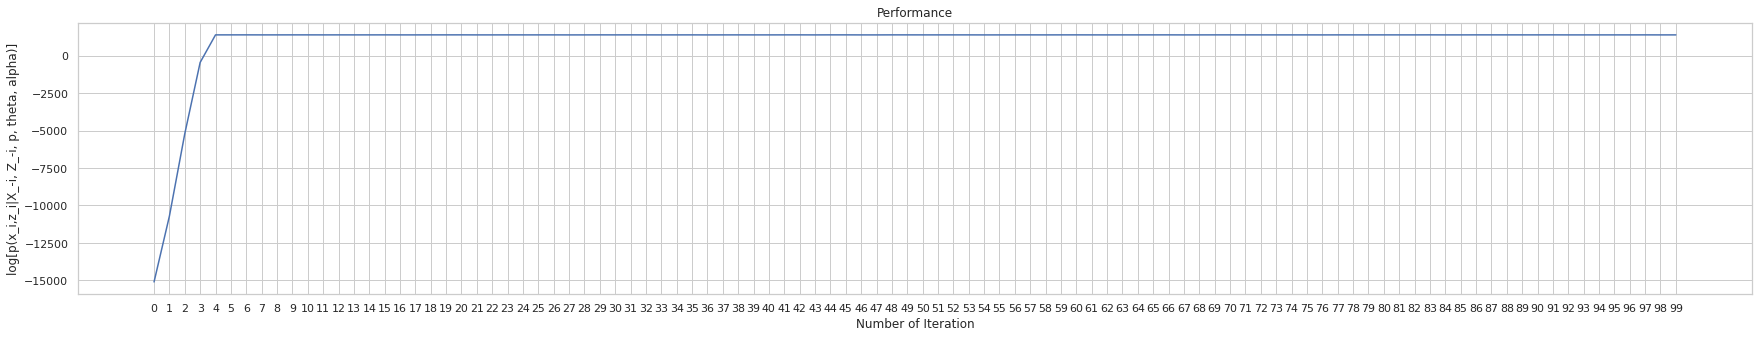

In [16]:
plt.figure(figsize=(30, 5))
plt.plot(total_performance)
plt.xlabel("Number of Iteration")
plt.ylabel("log[p(x_i,z_i|X_-i, Z_-i, p, theta, alpha)]")
plt.xticks([i for i in range(num_iter)])
plt.title("Performance")
plt.show()

In [17]:
for z in random_Z:
    proportion = Counter(random_Z[z])
    total = sum(proportion.values())

    print("For Dataset type:", z)
    for k in proportion:
        print("Cluster:", k, "Proportion:", proportion[k]/total)

For Dataset type: 0
Cluster: 0 Proportion: 1.0
For Dataset type: 1
Cluster: 3 Proportion: 1.0


In [18]:
params

{0: [{'pi': 0.5, 'mu': 40, 'sigma': 5}, {'pi': 0.5, 'mu': 85, 'sigma': 5}],
 1: [{'pi': 0.5, 'mu': 25, 'sigma': 5}, {'pi': 0.5, 'mu': 50, 'sigma': 5}]}

In [19]:
total_cluster_type

{0: {'mu': 86.54803172812227,
  'sigma': 0.8270222226893735,
  'child': {0: [0], 1: []}},
 1: {'mu': 86.53264917925775,
  'sigma': 0.8208146550600512,
  'child': {0: [0], 1: []}},
 2: {'mu': 49.16721076692397,
  'sigma': 0.03649912381590187,
  'child': {0: [], 1: [3]}}}